## Init

In [235]:
from google.colab import drive

drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
cd
drive

In [ ]:
cd
MyDrive

In [236]:
cd
Colab_Notebooks

NameError: name 'cd' is not defined

In [237]:
cd
Healthcare

NameError: name 'cd' is not defined

In [238]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Healthcare_Management.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [239]:
# !git add.

In [240]:
# !git commit -m "colab"

In [241]:
# !git pull

# preprocessing

## read file

In [242]:
from sklearn.impute import SimpleImputer
import os
import os
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True, precision=20, threshold=10, linewidth=40)  # np禁止科学计数法显示
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # pd禁止科学计数法显示

In [243]:
path = "data/train_data.csv"

df_all = pd.read_csv(path)  # 读取数据，根据你自己文件地址编写

df_all.drop_duplicates(inplace=True)  # 使用drop_duplicates去重，inplace=True对原数据集进行替换
df_all.reset_index(drop=True, inplace=True)  # 删除数据后，恢复索引

df_all

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.00,86499,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.00,325,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.00,125235,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.00,91081,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [244]:
# 整体查看数据类型 以及缺失情况
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [245]:
df_all['Hospital_code'] = df_all['Hospital_code'].astype(object)
df_all['City_Code_Hospital'] = df_all['City_Code_Hospital'].astype(object)
df_all['Bed Grade'] = df_all['Bed Grade'].astype(object)
df_all['City_Code_Patient'] = df_all['City_Code_Patient'].astype(object)

In [246]:
# 整体查看数据类型 以及缺失情况
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  object 
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  object 
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  object 
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [247]:
# 定义查找缺失变量函数，返回 缺失值率> 指定缺失率(narate) 的列表
def filter_col_by_nan(data, narate=0.2):
    '''
    :param data: 查找数据集
    :param narate: 设定变量的缺失值率
    :return: 返回 缺失率>narate的变量名称列表
    '''
    n_samples = data.shape[0]
    list_nan_cols = []
    for col in data.columns:
        if data[col].isna().sum() / n_samples >= (narate):
            list_nan_cols.append(col)

    print(f'缺失量在{narate * 100}%以上的变量有:{list_nan_cols}')

    return list_nan_cols


list_nullfactor_todrop = filter_col_by_nan(df_all, narate=0.3)

df_select = df_all.drop(list_nullfactor_todrop, axis=1).copy()
df_select

缺失量在30.0%以上的变量有:[]


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.00,86499,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.00,325,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.00,125235,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.00,91081,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [248]:
# 定义函数，返回离散型函数变量名列表, 并查看映射值数量情况
# def get_objectfac_list(data, print_value=False):
#     lt_discrete = []
#     for col in data.columns:
#         if str(data[col].dtype) == 'object':
#             lt_discrete.append(col)
#             if print_value == True:
#                 print(data[col].value_counts())
#                 print(f'-' * 50)
#     return lt_discrete

#list_discrete = get_objectfac_list(df_select,False)

# # 情况3，删除离散型变量，有空值的行
# df_select.dropna(axis=0,inplace=True)
# df_select.reset_index(drop=True, inplace=True)
#
# df_select

In [249]:
# 需要对数据进行划分

# ① 取数值、连续类型的数据
# list_train_num = ['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit']
#
# # ②取文本/离散、无需独热编码 类型的数据（类似 住宅类型、就业类型 等字段）
# list_train_str = ['Bed Grade', 'Type of Admission', 'Type of Admission', 'Age', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code',
#                           'Department', 'Ward_Type', 'Ward_Facility_Code', 'City_Code_Patient', 'Type of Admission',
#                           'Severity of Illness']

# # ③取文本/离散、需 独热编码 类型的数据（类似 教育水平分类 等变量）
# list_train_str_needtrf = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code',
#                           'Department', 'Ward_Type', 'Ward_Facility_Code', 'City_Code_Patient', 'Type of Admission',
#                           'Severity of Illness']

# 查看训练集空值情况（此时只剩数值型空值，其他类型的数据都被处理了）
# df_select[df_select.isnull().any(axis=1)].head()
# df_select

<Figure size 1080x576 with 0 Axes>

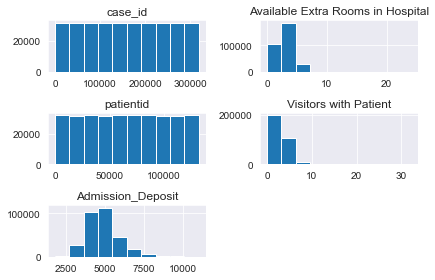

Skewness:


C:\Users\AORUS\AppData\Local\Temp\ipykernel_40436\3026752102.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_select.drop('Stay', axis=1).skew()


case_id                             -0.00
Hospital_code                       -0.28
City_Code_Hospital                   0.54
Available Extra Rooms in Hospital    0.97
Bed Grade                            0.05
patientid                            0.00
City_Code_Patient                    1.58
Visitors with Patient                3.14
Admission_Deposit                    0.93
dtype: float64

In [250]:
# Distribution of numeric independent variables

from matplotlib import pyplot as plt

plt.figure(figsize=(15, 8))

df_select.drop('Stay', axis=1).hist()
plt.tight_layout()
plt.show()

print('Skewness:')
df_select.drop('Stay', axis=1).skew()

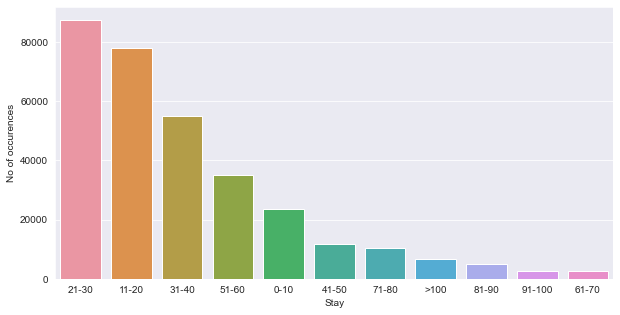

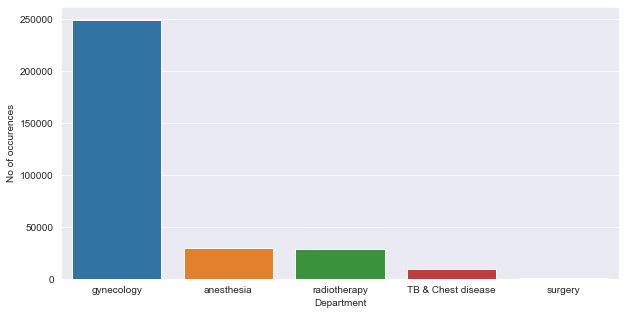

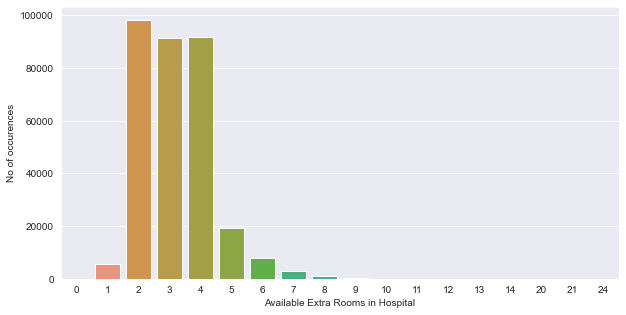

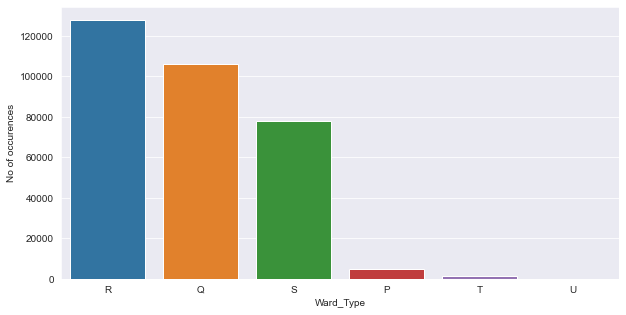

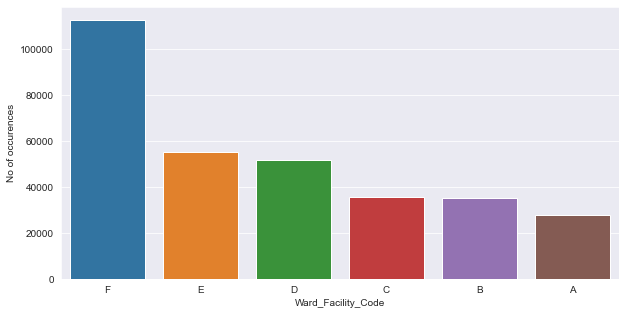

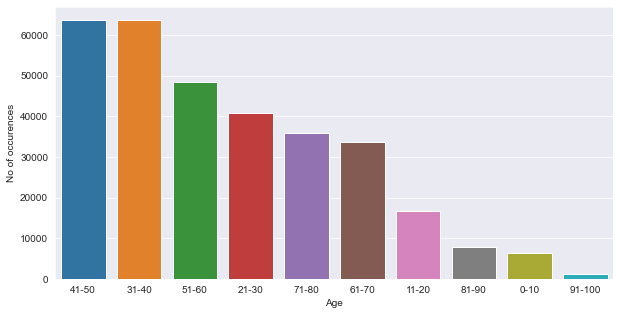

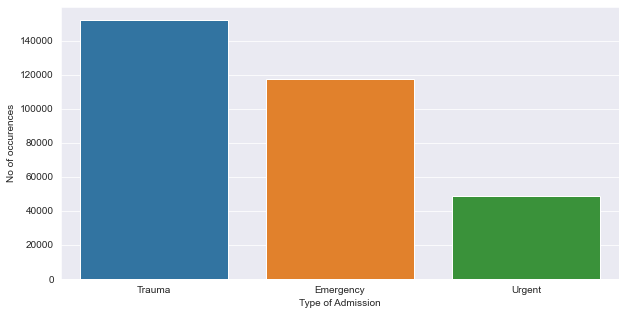

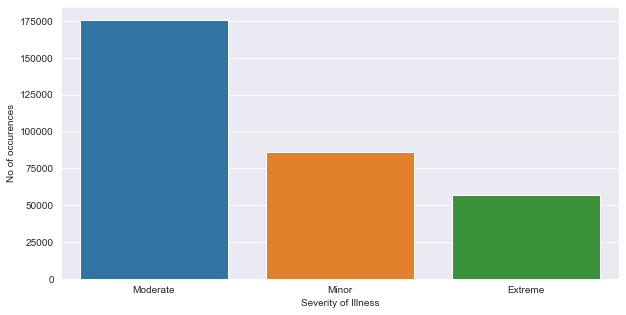

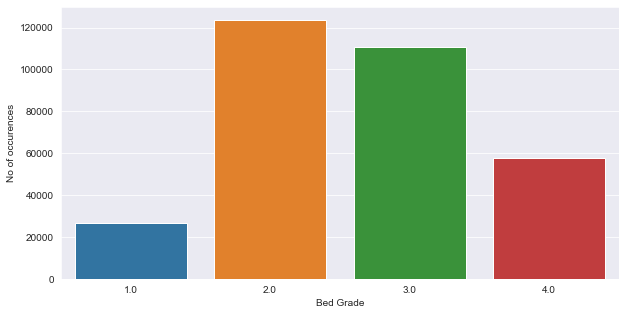

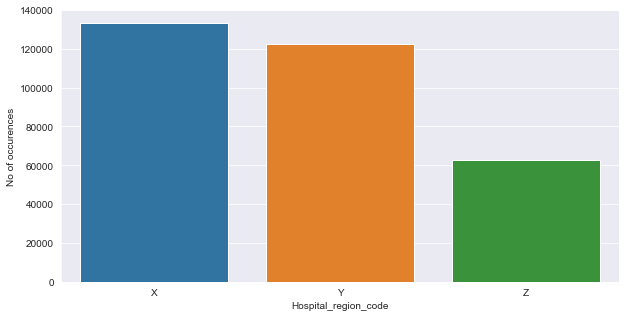

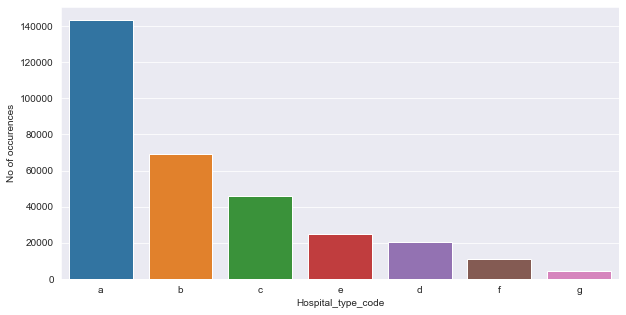

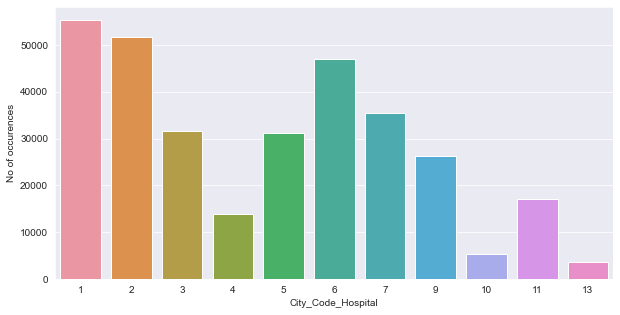

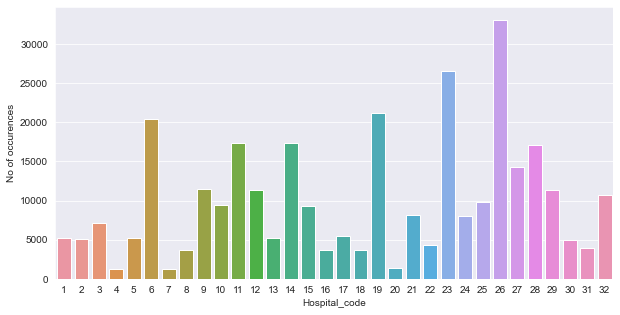

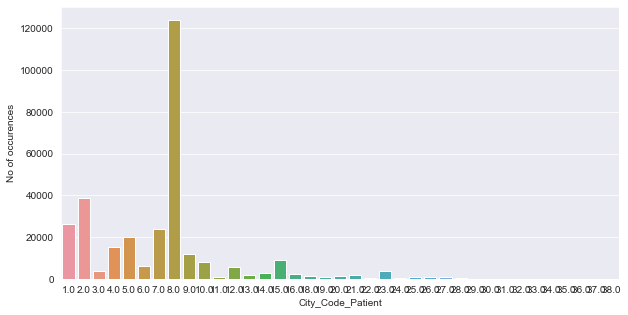

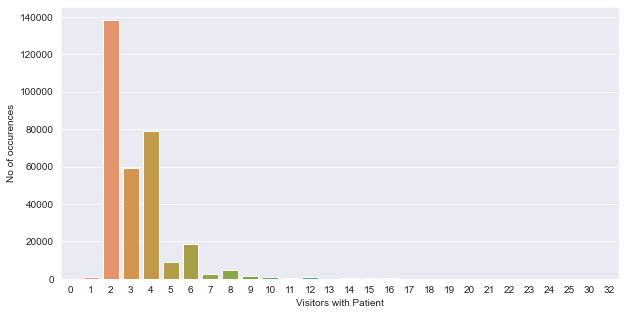

In [251]:
import seaborn as sns

# Univariate Analysis
df_select['Stay'].replace('More than 100 Days', '>100', inplace=True)

for i in ['Stay', 'Department', 'Available Extra Rooms in Hospital', 'Ward_Type', 'Ward_Facility_Code', 'Age',
          'Type of Admission', 'Severity of Illness', 'Bed Grade', 'Hospital_region_code', 'Hospital_type_code',
          'City_Code_Hospital', 'Hospital_code', 'City_Code_Patient', 'Visitors with Patient']:
    count = df_select[i].value_counts()

    plt.figure(figsize=(10, 5))

    sns.barplot(x=count.index.values, y=count.values, data=df_select)

    plt.xlabel(i)
    plt.ylabel('No of occurences')

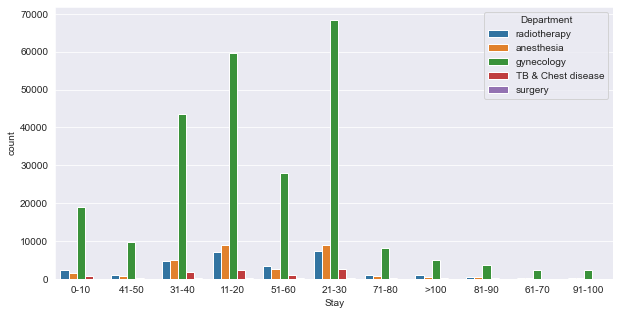

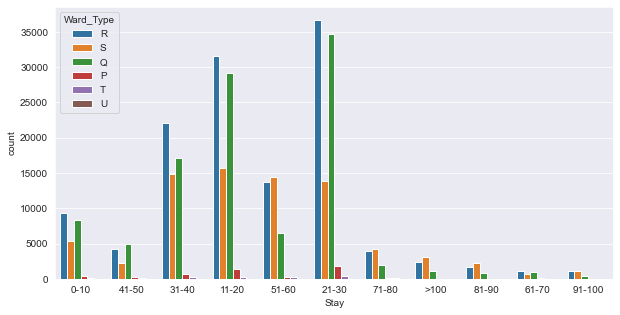

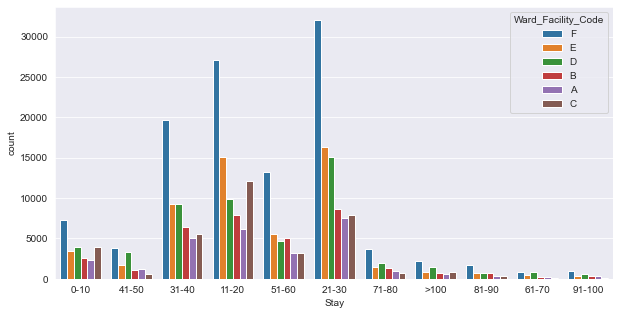

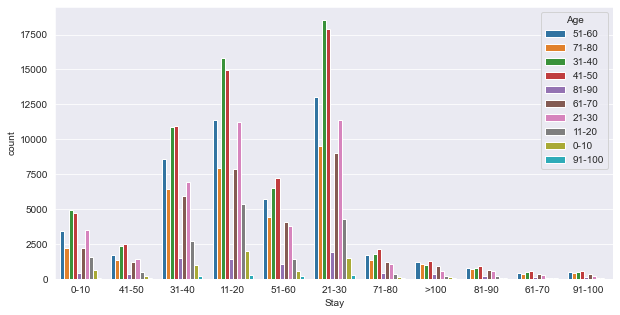

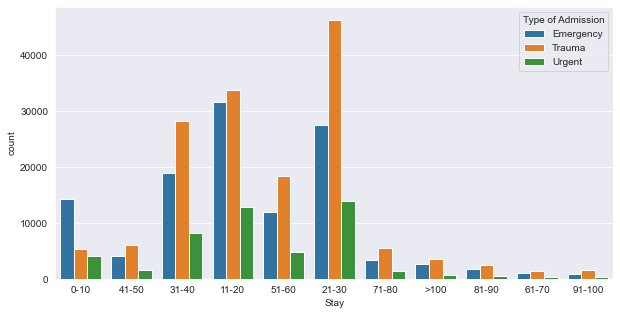

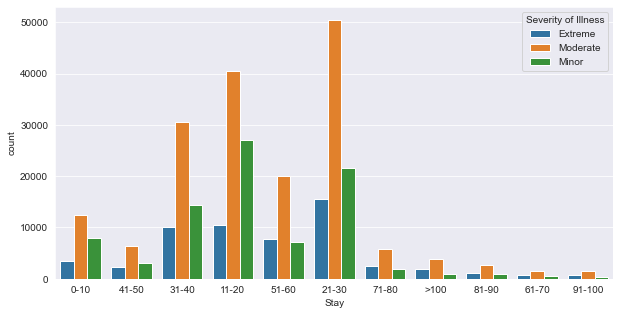

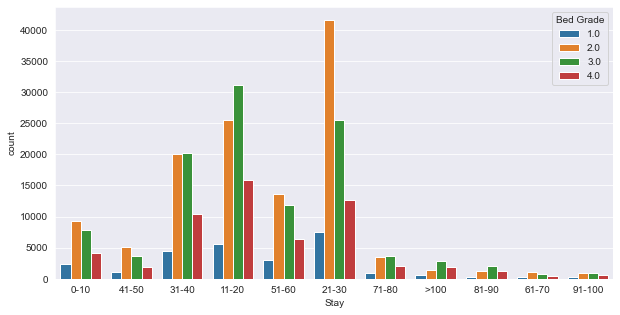

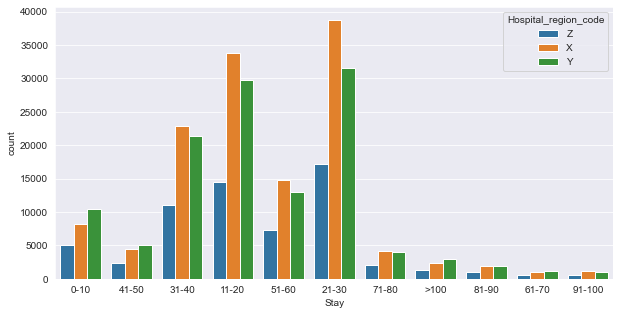

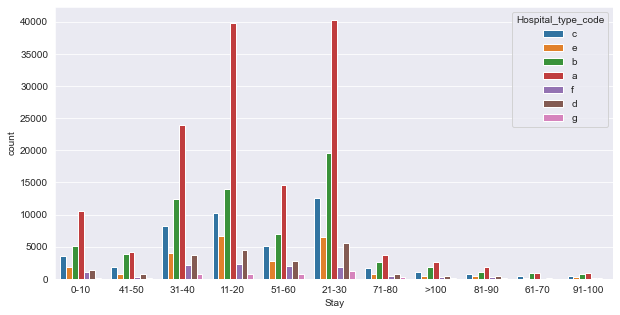

In [252]:
# Bivariate Analysis

for i in ['Department', 'Ward_Type', 'Ward_Facility_Code', 'Age', 'Type of Admission', 'Severity of Illness',
          'Bed Grade', 'Hospital_region_code', 'Hospital_type_code']:
    plt.figure(figsize=(10, 5))

    sns.countplot(x='Stay', hue=i, data=df_select)

C:\Users\AORUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Admission_Deposit', ylabel='Density'>

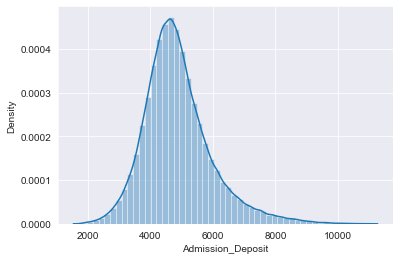

In [253]:
# Numerical Features
sns.distplot(df_select['Admission_Deposit'])



In [254]:
# df_num_train = df_select.select_dtypes([np.number])
# df_num_train.head()
# df_cat_train = df_select.select_dtypes([object])
# df_cat_train.head()

In [255]:
# df_cat_train['Stay']

## missing values

In [256]:
df_all.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [257]:
def impute_missing_values(df_all, columns):
    for column in columns:
        df_all[column] = df_all[column].fillna(df_all[column].most_frequent())

## Encoding

In [258]:
admission_encode = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
severity_encode = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}

df_select['Type of Admission'] = df_select['Type of Admission'].map(admission_encode)
df_select['Severity of Illness'] = df_select['Severity of Illness'].map(severity_encode)

df_select['Age'] = df_select['Age'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10})

df_select['Stay'] = df_select['Stay'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10, '>100': 11})

# df_cat_train['Stay'] = df_cat_train['Stay'].astype(int)

In [259]:
onehot_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code']

def onehot_encode(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data, dummies], axis=1)
        data.drop(column, axis=1, inplace = True)

    return data

data = onehot_encode(df_select, onehot_columns)
data

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,...,R,S,T,U,A,B,C,D,E,F
0,1,8,3,3,2.00,31397,7.00,3,3,2,...,1,0,0,0,0,0,0,0,0,1
1,2,2,5,2,2.00,31397,7.00,1,3,2,...,0,1,0,0,0,0,0,0,0,1
2,3,10,1,2,2.00,31397,7.00,1,3,2,...,0,1,0,0,0,0,0,0,1,0
3,4,26,2,2,2.00,31397,7.00,1,3,2,...,1,0,0,0,0,0,0,1,0,0
4,5,26,2,2,2.00,31397,7.00,1,3,2,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,6,3,4.00,86499,23.00,3,2,3,...,0,0,0,0,0,0,0,0,0,1
318434,318435,24,1,2,4.00,325,8.00,2,2,4,...,0,0,0,0,0,0,0,0,1,0
318435,318436,7,4,3,4.00,125235,10.00,3,1,3,...,1,0,0,0,0,0,0,0,0,1
318436,318437,11,2,3,3.00,91081,8.00,1,1,5,...,0,0,0,0,0,0,0,1,0,0


In [260]:
# from sklearn.preprocessing import LabelEncoder
#
# LE = LabelEncoder()
#
# df_cat_train['Hospital_code'] = LE.fit_transform(df_cat_train['Hospital_code'])
# df_cat_train['Hospital_type_code'] = LE.fit_transform(df_cat_train['Hospital_type_code'])
# df_cat_train['City_Code_Hospital'] = LE.fit_transform(df_cat_train['City_Code_Hospital'])
# df_cat_train['Hospital_region_code'] = LE.fit_transform(df_cat_train['Hospital_region_code'])
# df_cat_train['Department'] = LE.fit_transform(df_cat_train['Department'])
# df_cat_train['Ward_Type'] = LE.fit_transform(df_cat_train['Ward_Type'])
# df_cat_train['Ward_Facility_Code'] = LE.fit_transform(df_cat_train['Ward_Facility_Code'])
# df_cat_train['City_Code_Patient'] = LE.fit_transform(df_cat_train['City_Code_Patient'])
# df_cat_train['Bed Grade'] = LE.fit_transform(df_cat_train['Bed Grade'])
#
# df_cat_train.head()

In [261]:
# from sklearn.preprocessing import StandardScaler
#
# # For training Data
# sc = StandardScaler()
#
# num_scaled = sc.fit_transform(df_num_train)
# num_scaled

In [262]:
# df_num_scaled = pd.DataFrame(num_scaled, columns=df_num_train.columns)
# df_num_scaled = df_num_scaled.reset_index(drop=True)
# df_num_scaled

In [263]:
# df_full = pd.concat([df_num_scaled, df_cat_train], axis=1)
# df_full.shape


In [264]:
# sns.heatmap(df_select.corr(), annot=True)

## Scaling

In [265]:
from sklearn.preprocessing import StandardScaler

In [266]:
data.set_index('case_id', inplace = True)

y = data['Stay']
X = data.drop(['Stay'], axis=1)

In [267]:
y

case_id
1         1
2         5
3         4
4         5
5         5
         ..
318434    2
318435    4
318436    2
318437    2
318438    1
Name: Stay, Length: 318438, dtype: int64

In [268]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)

In [269]:
X

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
1,-1.20,-0.57,-0.17,-0.72,-0.90,-0.05,1.21,1.65,-0.73,0.46,...,1.22,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,-0.46,1.35
2,-1.89,0.07,-1.03,-0.72,-0.90,-0.05,-0.97,1.65,-0.73,0.46,...,-0.82,1.76,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,-0.46,1.35
3,-0.96,-1.22,-1.03,-0.72,-0.90,-0.05,-0.97,1.65,-0.73,0.46,...,-0.82,1.76,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,2.18,-0.74
4,0.89,-0.89,-1.03,-0.72,-0.90,-0.05,-0.97,1.65,-0.73,0.46,...,1.22,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,2.27,-0.46,-0.74
5,0.89,-0.89,-1.03,-0.72,-0.90,-0.05,-0.97,1.65,-0.73,0.46,...,-0.82,1.76,-0.07,-0.01,-0.31,-0.35,-0.35,2.27,-0.46,-0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318434,-1.43,0.40,-0.17,1.57,0.55,3.32,1.21,0.14,-0.16,-0.07,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,-0.46,1.35
318435,0.66,-1.22,-1.03,1.57,-1.72,0.16,0.12,0.14,0.41,2.05,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,2.18,-0.74
318436,-1.31,-0.25,-0.17,1.57,1.57,0.58,1.21,-1.37,-0.16,1.52,...,1.22,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,-0.46,1.35


## 数据清洗函数定义

In [270]:
# # 数据清洗函数定义
# from sklearn.impute import SimpleImputer
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.utils import check_array
# from scipy import sparse
#
#
# class CategoricalEncoder(BaseEstimator, TransformerMixin):
#     """将分类特征编码为数字数组。
#     此函数输入 分类的整数矩阵 或 字符串矩阵,
#     将把分类（离散）特征所具有的值转化为数组
#
#     """
#
#     def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
#                  handle_unknown='error'):
#         self.encoding = encoding
#         self.categories = categories
#         self.dtype = dtype
#         self.handle_unknown = handle_unknown
#
#     def fit(self, X, y=None):
#         """Fit the CategoricalEncoder to X.
#         Parameters
#         ----------
#         X : array-like, shape [n_samples, n_feature]
#             The data to determine the categories of each feature.
#         Returns
#         -------
#         self
#         """
#
#         # 报错预警
#         if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
#             template = ("encoding should be either 'onehot', 'onehot-dense' "
#                         "or 'ordinal', got %s")
#             raise ValueError(template % self.handle_unknown)
#
#         if self.handle_unknown not in ['error', 'ignore']:
#             template = ("handle_unknown should be either 'error' or "
#                         "'ignore', got %s")
#             raise ValueError(template % self.handle_unknown)
#
#         if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
#             raise ValueError("handle_unknown='ignore' is not supported for"
#                              " encoding='ordinal'")
#
#         X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
#         n_samples, n_features = X.shape  # n_samples 样本数，n_features 特征数
#
#         self._label_encoders_ = [LabelEncoder() for n_f in range(n_features)]
#
#         for i in range(n_features):
#             le = self._label_encoders_[i]
#             Xi = X[:, i]
#             if self.categories == 'auto':
#                 le.fit(Xi)
#             else:
#                 valid_mask = np.in1d(Xi, self.categories[i])
#                 if not np.all(valid_mask):
#                     if self.handle_unknown == 'error':
#                         diff = np.unique(Xi[~valid_mask])
#                         msg = ("Found unknown categories {0} in column {1}"
#                                " during fit".format(diff, i))
#                         raise ValueError(msg)
#                 le.classes_ = np.array(np.sort(self.categories[i]))
#
#         self.categories_ = [le.classes_ for le in self._label_encoders_]
#
#         return self
#
#     def transform(self, X):
#         """Transform X using one-hot encoding.
#         Parameters
#         ----------
#         X : array-like, shape [n_samples, n_features]
#             The data to encode.
#         Returns
#         -------
#         X_out : sparse matrix or a 2-d array
#             Transformed input.
#         """
#         X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
#         n_samples, n_features = X.shape
#
#         X_int = np.zeros_like(X, dtype=np.int)  # 构建一个和 X 维度相同的(一毛一样)  整数零矩阵
#         X_mask = np.ones_like(X, dtype=np.bool)  # 构建一个和 X 维度相同的(一毛一样)   布尔矩阵
#
#         for i in range(n_features):  # 对每个变量开始循环
#             valid_mask = np.in1d(X[:, i], self.categories_[i])  # 每个变量的每一行，去验证是否是是此变量unqiue中的一个，是返回True
#
#             if not np.all(valid_mask):
#                 if self.handle_unknown == 'error':
#                     diff = np.unique(X[~valid_mask, i])
#                     msg = ("Found unknown categories {0} in column {1}"
#                            " during transform".format(diff, i))
#                     raise ValueError(msg)
#                 else:
#                     # Set the problematic rows to an acceptable value and
#                     # continue `The rows are marked `X_mask` and will be
#                     # removed later.
#                     X_mask[:, i] = valid_mask  # unique矩阵赋予X_mask
#                     X[:, i][~valid_mask] = self.categories_[i][0]
#             X_int[:, i] = self._label_encoders_[i].transform(X[:, i])
#
#         if self.encoding == 'ordinal':
#             return X_int.astype(self.dtype, copy=False)
#
#         mask = X_mask.ravel()  # .ravel()将矩阵向量化
#
#         n_values = [cats.shape[0] for cats in self.categories_]
#
#         n_values = np.array([0] + n_values)
#         indices = np.cumsum(n_values)
#
#         column_indices = (X_int + indices[:-1]).ravel()[mask]  # 找到该变量某个离散值中的所有的列索引
#         row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
#                                 n_features)[mask]
#         data = np.ones(n_samples * n_features)[mask]
#
#         out = sparse.csc_matrix((data, (row_indices, column_indices)),
#                                 shape=(n_samples, indices[-1]),
#                                 dtype=self.dtype).tocsr()
#         # out = out[:,1:] # 这里为one_hot,如果要转换成哑变量需要将状态进行k-1删除，防止虚拟陷阱！
#
#         if self.encoding == 'onehot-dense':
#             return out.toarray()
#         else:
#             return out

In [271]:
# class DataFrameSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
#
#     def fit(self, X, y=None):
#         return self
#
#     def transform(self, X):
#         return X[self.attribute_names].values

In [272]:
# class ExeLabelEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self._stretltype = 1
#
#     def fit(self, X, y=None):
#         return self
#
#     def transform(self, X):
#         encoder = LabelEncoder()
#         n_samples, n_features = X.shape
#         arr = np.zeros_like(X, dtype=np.int)
#
#         for whlist in range(X.shape[1]):
#             arr[:, whlist] = encoder.fit_transform(X[:, whlist])
#         return arr

## split dataset

In [273]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [274]:
# X = sm.add_constant(X)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, random_state=10, test_size=0.3)

Xtrain

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
82088,-0.50,-1.22,0.69,0.43,0.26,-1.11,1.21,0.14,-0.73,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,2.18,-0.74
270707,-0.04,2.65,-0.17,-0.72,-1.36,0.16,1.21,0.14,-0.16,-1.13,...,-0.82,-0.57,14.65,-0.01,-0.31,2.84,-0.35,-0.44,-0.46,-0.74
264478,0.08,0.72,-0.17,0.43,0.59,3.32,1.21,1.65,-0.16,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74
142665,0.54,0.40,-0.17,1.57,-1.24,-1.11,-0.97,0.14,-0.16,-0.60,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,-0.46,1.35
214946,1.58,1.36,-1.03,0.43,-0.77,0.16,-0.97,-1.37,-0.73,-0.07,...,-0.82,1.76,-0.07,-0.01,-0.31,2.84,-0.35,-0.44,-0.46,-0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.08,0.72,-0.17,-0.72,1.51,0.16,1.21,-1.37,0.41,-0.60,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74
9373,0.77,-1.22,0.69,0.43,-0.34,0.16,-0.97,0.14,0.41,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,2.18,-0.74
105596,0.08,0.72,-1.03,-0.72,-0.35,0.16,1.21,0.14,0.41,-0.07,...,-0.82,1.76,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74


In [275]:
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(222906, 38)
(95532, 38)
(222906,)
(95532,)


In [276]:
# 利用Pipeline定义不同变量清洗过程
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler  # 数据标准化
#
# # 连续型：处理顺序为1.DataFrameSelector 选择数据集，2.SimpleImputer填充缺失值，3.StandardScaler进行标准化数据
# num_pipeline = Pipeline([
#     ('selector', DataFrameSelector(list_train_num)),
#     ('simple_imputer', SimpleImputer(strategy="most_frequent")),
#     # median为中位数，most_frequent为众数。constant表示将空值填充为自定义的值，但这个自定义的值要通过fill_value来定义
#     ('std_scaler', StandardScaler()),  # 进行标准化
# ])
#
# # 离散，将数据转化为 数字
# cat_pipeline = Pipeline([
#     ('selector', DataFrameSelector(list_train_str)),
#     ('simple_imputer', SimpleImputer(strategy="most_frequent")),
#     ('label_encoder', ExeLabelEncoder()),  # 进行 ExeLabelEncoder
# ])

# # 离散，将数据转化为 数字，并进行onehot编码
# cat_onehot_pipeline = Pipeline([  # 类别需要onehot编码
#     ('selector', DataFrameSelector(list_train_str_needtrf)),
#     ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
# ])

Xtrain

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
82088,-0.50,-1.22,0.69,0.43,0.26,-1.11,1.21,0.14,-0.73,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,2.18,-0.74
270707,-0.04,2.65,-0.17,-0.72,-1.36,0.16,1.21,0.14,-0.16,-1.13,...,-0.82,-0.57,14.65,-0.01,-0.31,2.84,-0.35,-0.44,-0.46,-0.74
264478,0.08,0.72,-0.17,0.43,0.59,3.32,1.21,1.65,-0.16,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74
142665,0.54,0.40,-0.17,1.57,-1.24,-1.11,-0.97,0.14,-0.16,-0.60,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,-0.46,1.35
214946,1.58,1.36,-1.03,0.43,-0.77,0.16,-0.97,-1.37,-0.73,-0.07,...,-0.82,1.76,-0.07,-0.01,-0.31,2.84,-0.35,-0.44,-0.46,-0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.08,0.72,-0.17,-0.72,1.51,0.16,1.21,-1.37,0.41,-0.60,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74
9373,0.77,-1.22,0.69,0.43,-0.34,0.16,-0.97,0.14,0.41,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,2.18,-0.74
105596,0.08,0.72,-1.03,-0.72,-0.35,0.16,1.21,0.14,0.41,-0.07,...,-0.82,1.76,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74


In [277]:
Ytrain

case_id
82088     4
270707    2
264478    2
142665    3
214946    6
         ..
299742    2
9373      3
105596    4
93554     2
236670    2
Name: Stay, Length: 222906, dtype: int64

In [278]:
# K Fold Cross Validation
# from sklearn.model_selection import KFold,cross_val_score
# kfold=KFold(n_splits=10, shuffle=True, random_state=10)


In [279]:
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
#
# LR = LogisticRegression()
#
# LR.fit(Xtrain,Ytrain)
#
# y_pred_LR=LR.predict(Xtest)
# accuracy_score(Ytest,y_pred_LR)*100

In [280]:
# 定义FeatureUnion 进行流水化清洗数据
# from sklearn.pipeline import FeatureUnion
#
# full_pipeline = FeatureUnion(transformer_list=[
#     ("num_pipeline", num_pipeline),
#     ("cat_pipeline", cat_pipeline)
# ])
#
# df_select_prepared = full_pipeline.fit_transform(Xtrain)  # 使用流水线清洗数据，对Xtrain进行etl
# df_select_test = full_pipeline.fit_transform(Xtest)  # 使用流水线清洗数据，对Xtest进行etl
Ytrain

case_id
82088     4
270707    2
264478    2
142665    3
214946    6
         ..
299742    2
9373      3
105596    4
93554     2
236670    2
Name: Stay, Length: 222906, dtype: int64

In [281]:

Xtrain  # 查看清洗后的数据维度（行列）

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
82088,-0.50,-1.22,0.69,0.43,0.26,-1.11,1.21,0.14,-0.73,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,2.18,-0.74
270707,-0.04,2.65,-0.17,-0.72,-1.36,0.16,1.21,0.14,-0.16,-1.13,...,-0.82,-0.57,14.65,-0.01,-0.31,2.84,-0.35,-0.44,-0.46,-0.74
264478,0.08,0.72,-0.17,0.43,0.59,3.32,1.21,1.65,-0.16,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74
142665,0.54,0.40,-0.17,1.57,-1.24,-1.11,-0.97,0.14,-0.16,-0.60,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,-0.46,1.35
214946,1.58,1.36,-1.03,0.43,-0.77,0.16,-0.97,-1.37,-0.73,-0.07,...,-0.82,1.76,-0.07,-0.01,-0.31,2.84,-0.35,-0.44,-0.46,-0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.08,0.72,-0.17,-0.72,1.51,0.16,1.21,-1.37,0.41,-0.60,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74
9373,0.77,-1.22,0.69,0.43,-0.34,0.16,-0.97,0.14,0.41,0.46,...,-0.82,-0.57,-0.07,-0.01,-0.31,-0.35,-0.35,-0.44,2.18,-0.74
105596,0.08,0.72,-1.03,-0.72,-0.35,0.16,1.21,0.14,0.41,-0.07,...,-0.82,1.76,-0.07,-0.01,-0.31,-0.35,2.82,-0.44,-0.46,-0.74


Feature Selection

In [282]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE


In [283]:
# 1.构建RF模型
RFC_ = RFC()  # 随机森林
c = RFC_.fit(Xtrain, Ytrain).feature_importances_  # 特征重要性
print("重要性：")
c

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:

# # 2. 交叉验证递归特征消除法
# selector = RFECV(RFC_, step=1, cv=10)  # 采用交叉验证，每次排除一个特征，筛选出最优特征
# selector = selector.fit(Xtrain, Ytrain)
# X_wrapper = selector.transform(Xtrain)  # 最优特征
# score = cross_val_score(RFC_, X_wrapper, Ytrain, cv=10).mean()  # 最优特征分类结果
# print(score)
# print("最佳数量和排序")
# print(selector.support_)  # 选取结果
# print(selector.n_features_)  # 选取特征数量
# print(selector.ranking_)  # 依次排数特征排序

In [ ]:
# print(score)
# print("最佳数量和排序")
# selector.support_  # 选取结果

In [ ]:
# 3.递归特征消除法
selector1 = RFE(RFC_, n_features_to_select=3, step=1).fit(Xtrain,
                                                          Ytrain)  # n_features_to_select表示筛选最终特征数量，step表示每次排除一个特征
selector1.support_.sum()
print(selector1.ranking_)  # 特征排除排序
print(selector1.n_features_)  # 选择特征数量
X_wrapper1 = selector1.transform(Xtrain)  # 最优特征
score = cross_val_score(RFC_, X_wrapper1, Ytrain, cv=9).mean()
score

In [ ]:
selector1.n_features_  # 选取特征数量

In [ ]:
selector1.ranking_

In [ ]:
selector1.support_

In [ ]:

# # 4.递归特征消除法和曲线图选取最优特征数量
# score = []  # 建立列表
# for i in range(1, 17, 1):
#     X_wrapper = RFE(RFC_, n_features_to_select=i, step=1).fit_transform(Xtrain, Ytrain)  # 最优特征
#     once = cross_val_score(RFC_, X_wrapper, Ytrain, cv=9).mean()  # 交叉验证
#     score.append(once)  # 交叉验证结果保存到列表
# print(max(score), (score.index(max(score)) * 1) + 1)  # 输出最优分类结果和对应的特征数量
# print(score)
# plt.figure(figsize=[20, 5])
# plt.plot(range(1, 17, 1), score)
# plt.xticks(range(1, 17, 1))
# plt.show()

In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# #递归特征消除法，返回特征选择后的数据
# #参数estimator为基模型
# #参数n_features_to_select为选择的特征个数
# RFE = RFE(LogisticRegression(),
#     n_features_to_select=2).fit(Xtrain,
#                                 Ytrain)

In [ ]:
# RFE.ranking_

In [ ]:
Xtrain

In [ ]:
list_factor_todrop = ['Hospital_type_code', 'Hospital_region_code', 'Ward_Facility_Code']  #需要抛弃的变量
Xtrain.drop(list_factor_todrop, axis=1, inplace=True)
Xtest.drop(list_factor_todrop, axis=1, inplace=True)


Logistic Regression

In [ ]:
from mlxtend.classifier import LogisticRegression as LR
from sklearn.metrics import accuracy_score
# LR.fit(np.array([[1],[4],[2]]), np.array([1,0,1]))
# LR.predict(np.array([[1],[4],[2]]))

In [ ]:
# Ytrain

In [ ]:
# from mlxtend.classifier import LogisticRegression
# from sklearn.metrics import accuracy_score
#
# LR = LogisticRegression()
#
# LR.fit(Xtrain,Ytrain)
#
# y_pred_LR=LR.predict(Xtest)
# accuracy_score(Ytest,y_pred_LR)*100

In [ ]:
# from sklearn.metrics import classification_report
#
# print(classification_report(Ytest,y_pred_LR))


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classification = DecisionTreeClassifier(criterion='entropy', random_state=10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT = decision_tree.predict(Xtest)
accuracy_score(Ytest, y_pred_DT) * 100

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Ytest, y_pred_DT))

Tuned HyperParameter Decision Tree

In [ ]:
from tqdm import tqdm
accuracy_score_list = []
for i in range(1, 41):
    dt_tuned = DecisionTreeClassifier(criterion='gini', splitter="best", max_depth=i, random_state=10)
    decision_tree_tuned = dt_tuned.fit(Xtrain, Ytrain)
    y_pred_DT_tuned = decision_tree_tuned.predict(Xtest)
    print("current_depth: " + str(i), end="\t")
    accuracy = accuracy_score(Ytest, y_pred_DT_tuned) * 100
    print("accuracy: " + str(accuracy))
    accuracy_score_list.append(float(accuracy))


In [ ]:
plt.figure(figsize=[41, 20])
plt.plot(range(1, 41), accuracy_score_list)
plt.xticks(range(1, 41))
plt.show()
value = max(accuracy_score_list)
print("the best value of HyperParameter——max_depth: " + str(accuracy_score_list.index(value)+1))

In [ ]:

print(classification_report(Ytest, y_pred_DT_tuned))

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classification = RandomForestClassifier(random_state=10)

rf_model = rf_classification.fit(Xtrain, Ytrain)
y_pred_RF = rf_model.predict(Xtest)
accuracy_score(Ytest, y_pred_RF) * 100

In [ ]:
print(classification_report(Ytest, y_pred_RF))

Gradient boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GB=GradientBoostingClassifier(random_state=10)

GB.fit(Xtrain, Ytrain)
y_pred_GB = GB.predict(Xtest)
accuracy_score(Ytest,y_pred_GB)*100

In [ ]:
print(classification_report(Ytest,y_pred_GB))

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(Xtrain, Ytrain)

y_pred_NB = NB.predict(Xtest)
accuracy_score(Ytest, y_pred_NB) * 100

In [ ]:
print(classification_report(Ytest, y_pred_NB))

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(Xtrain, Ytrain)

In [ ]:
y_pred_KNN = NB.predict(Xtest)
accuracy_score(Ytest, y_pred_KNN) * 100

In [ ]:
print(classification_report(Ytest, y_pred_NB))